In [15]:
import sys
from PIL import Image
sys.path.append('..') 
from classes import IMAGENET2012_CLASSES
import sys
import seaborn as sns


In [16]:
import os
import torch
from transformers import (
    AutoModelForCausalLM,  
    AutoTokenizer,        
    AutoModel,
    AutoImageProcessor ,
    ViTForImageClassification
)
import argparse  
import time      
import numpy as np  
import json          
from tqdm import tqdm 
import random         
import pandas as pd    
from sklearn.feature_selection import mutual_info_regression  
from sklearn.neighbors import NearestNeighbors              
import pickle          
import logging         
import gc   
import matplotlib.pyplot as plt
import re



In [17]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using GPU:", torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print("Using CPU")

Using GPU: NVIDIA GeForce GTX 1650


In [18]:
           

# Define the possible choices for multiple-choice questions
choices = ["A", "B", "C", "D"]

def format_example(df, idx, include_answer=True):
    """
    Formats a single example from the DataFrame into a image prompt.

    Args:
        df (pd.DataFrame): The DataFrame containing the data.
        idx (int): The index of the row to format.
        include_answer (bool): Whether to include the correct answer.

    Returns:
        PIL object: The PIL string.
    """
    val_dir = r'C:\Users\hp\Desktop\mka on VIT-mae\Pruning-via-Merging\val_images'
    image_path = os.path.join(val_dir, df.iloc[idx,0])
    return Image.open(image_path)

def set_seed(seed: int = 1):
    """
    Sets the random seed for reproducibility across various libraries and environments.

    Args:
        seed (int, optional): The seed value to set. Defaults to 1.
    """
    random.seed(seed)  # Set seed for Python's random module
    np.random.seed(seed)  # Set seed for NumPy
    os.environ["PYTHONHASHSEED"] = str(seed)  # Set seed for Python hash-based operations
    torch.manual_seed(seed)  # Set seed for PyTorch CPU
    torch.cuda.manual_seed(seed)  # Set seed for PyTorch CUDA
    torch.backends.cudnn.deterministic = True  # Ensure deterministic behavior in cuDNN
    torch.backends.cudnn.benchmark = False     # Disable cuDNN benchmark for consistency

def adaptive_chunk_size(total_size, preferred_size=100):
    """
    Determines the optimal chunk size for processing to maximize efficiency.

    Args:
        total_size (int): The total number of elements to process.
        preferred_size (int, optional): The preferred chunk size. Defaults to 100.

    Returns:
        int: The adaptive chunk size.
    """
    # Iterate from preferred_size down to 1 to find the largest divisor of total_size
    for size in range(preferred_size, 0, -1):
        if total_size % size == 0:
            return size
    return 1  # Fallback to 1 if no divisor is found

def L2_distance_chunked(a, b, df, total_size):
    """
    Generates L2 distance chunks between two arrays in an adaptive chunked manner.

    Args:
        a (np.ndarray): First array of shape (n_samples_a, n_features).
        b (np.ndarray): Second array of shape (n_samples_b, n_features).
        df (int): Flag to determine if diagonal should be zeroed.
        total_size (int): Total number of samples.

    Yields:
        np.ndarray: A chunk of L2 distances.
    """
    # Determine the chunk size adaptively
    chunk_size = adaptive_chunk_size(total_size)
    # Reshape a and b if they have more than 2 dimensions
    if a.ndim > 2:
        a = a.reshape(-1, a.shape[-1])
    if b.ndim > 2:
        b = b.reshape(-1, b.shape[-1])

    # Ensure a and b have the same number of features
    assert a.shape[1] == b.shape[1], "Incompatible shapes"

    # Iterate over chunks of a
    for i in range(0, a.shape[0], chunk_size):
        # Compute squared norms for the current chunk of a
        aa = np.sum(a[i : i + chunk_size] ** 2, axis=1, keepdims=True)
        # Iterate over chunks of b
        for j in range(0, b.shape[0], chunk_size):
            # Compute squared norms for the current chunk of b
            bb = np.sum(b[j : j + chunk_size] ** 2, axis=1, keepdims=True).T
            # Compute the dot product between chunks of a and b
            ab = a[i : i + chunk_size] @ b[j : j + chunk_size].T
            # Compute the L2 distance chunk
            d_chunk = np.sqrt(np.abs(aa + bb - 2 * ab))

            # If df flag is set to 1 and processing diagonal chunks, set diagonal to 0
            if df == 1:
                if i == j:
                    np.fill_diagonal(d_chunk, 0)  # Set diagonal to 0 if needed

            # Yield the computed distance chunk
            yield d_chunk

def diffusionKernel(X, sigmaK, alpha, d, total_size):
    """
    Computes the diffusion kernel embedding for the dataset X.

    Args:
        X (np.ndarray): Input data of shape (n_samples, n_features).
        sigmaK (float): Kernel scale parameter.
        alpha (float): Scaling factor for normalization.
        d (int): Target dimensionality for embedding.
        total_size (int): Total number of samples.

    Returns:
        np.ndarray: Embedded data of shape (n_samples, d).
    """
    # Determine the optimal chunk size for processing
    chunk_size = adaptive_chunk_size(total_size)
    print("Starting diffusion kernel computation...")
    kernel_start_time = time.time()

    n = X.shape[0]  # Number of samples
    # Initialize the kernel matrix with zeros
    K = np.zeros((n, n), dtype=np.float32)

    # Iterate over chunks of X to compute the kernel matrix
    for i in range(0, n, chunk_size):
        for j in range(0, n, chunk_size):
            i_end = min(i + chunk_size, n)
            j_end = min(j + chunk_size, n)
            # Compute the L2 distance chunk between X[i:i_end] and X[j:j_end]
            D_chunk = next(L2_distance_chunked(X[i:i_end], X[j:j_end], df=1, total_size=n))
            # Compute the kernel chunk using the diffusion kernel formula
            K_chunk = np.exp(-((D_chunk / sigmaK) ** 0.5))
            # Assign the computed chunk to the appropriate position in K
            K[i:i_end, j:j_end] = K_chunk[: i_end - i, : j_end - j]

    # Calculate the sum of the kernel matrix along columns
    p = np.sum(K, axis=0)
    # Normalize the kernel matrix
    K1 = K / (p * p.reshape(-1, 1)) ** alpha
    # Compute the normalization factor
    v = np.sqrt(np.sum(K1, axis=0))
    # Normalize the kernel matrix further
    A = K1 / np.outer(v, v)

    # Compute the condition number of the matrix A for numerical stability
    cond_num = np.linalg.cond(A)
    print(f"Condition number: {cond_num}")

    # If the condition number is infinite, apply regularization to stabilize
    if np.isinf(cond_num):
        print("Infinite condition number detected. Applying regularization...")
        regularization = 1e-6
        max_iterations = 10
        iteration = 0
        while np.isinf(cond_num) and iteration < max_iterations:
            # Add a small value to the diagonal for regularization
            A += np.eye(A.shape[0]) * regularization
            cond_num = np.linalg.cond(A)
            regularization *= 10  # Increase regularization factor exponentially
            iteration += 1
        print(f"Regularization applied. New condition number: {cond_num}")

    # Replace any NaNs in A with zero
    A = np.nan_to_num(A)

    # Handle very small values by setting them to a minimum threshold
    zero_mask = np.abs(A) < 1e-12
    A[zero_mask] = 1e-12

    # Perform Singular Value Decomposition (SVD) on the matrix A
    U, S, V = np.linalg.svd(A, full_matrices=False)
    # Retain only the top (d + 1) singular vectors
    U = U[:, :d + 1]
    # Avoid division by zero by replacing zeros in the first column
    U[:, 0] = np.where(U[:, 0] == 0, 1e-8, U[:, 0])
    # Normalize U by the first column
    U = U / U[:, 0].reshape(-1, 1)

    # Extract the embedded coordinates excluding the first column
    Y = U[:, 1 : d + 1]

    kernel_end_time = time.time()
    print(f"Diffusion kernel computation completed in {kernel_end_time - kernel_start_time:.2f} seconds.")
    return Y

def extract_layer_params(model, layer_idx, input_ids):
    """
    Extracts the activations from a specific layer of the model given input tokens.

    Args:
        model (torch.nn.Module): The language model.
        layer_idx (int): The index of the layer to extract.
        input_ids (torch.Tensor): Tokenized input IDs.

    Returns:
        np.ndarray: Activations from the specified layer, adjusted to a maximum length of 512.
    """
    # Perform a forward pass with no gradient computation to get hidden states
    with torch.no_grad():
        outputs = model(**input_ids, output_hidden_states=True)
        hidden_states = outputs.hidden_states  # List of hidden states from each layer
        # Extract activations from the specified layer and move to CPU
        activations = hidden_states[layer_idx].detach().float().cpu().numpy()

    # Define the maximum sequence length
    max_length = 512
    # If the sequence length is shorter than max_length, pad with zeros
    if activations.shape[1] < max_length:
        padding = max_length - activations.shape[1]
        activations = np.pad(activations, ((0, 0), (0, padding), (0, 0)), "constant")
    # If the sequence length is longer than max_length, truncate
    elif activations.shape[1] > max_length:
        activations = activations[:, :max_length, :]

    return activations

def load_embeddings(directory_path):
    """
    Loads and preprocesses layer embeddings from pickle files in the specified directory.

    Args:
        directory_path (str): Path to the directory containing embedding files.

    Returns:
        list: A list of NumPy arrays containing embeddings for each layer.
    """
    embeddings = []  # List to store embeddings from each file
    # Sort filenames based on the numerical value after the first underscore
    filenames = sorted(
        os.listdir(directory_path), key=lambda x: int(x.split("_")[1].split(".")[0])
    )
    # Iterate over each file in the sorted list
    for filename in filenames:
        if filename.endswith(".pkl"):  # Process only pickle files
            with open(os.path.join(directory_path, filename), "rb") as f:
                embedding = pickle.load(f)
                # Replace NaNs and infinite values with zeros
                embedding = np.nan_to_num(embedding, nan=0.0, posinf=0.0, neginf=0.0)

                # Apply rank normalization to the embeddings
                embedding = (
                    np.argsort(np.argsort(embedding, axis=0), axis=0)
                    / embedding.shape[0]
                )

                # Append the preprocessed embedding to the list
                embeddings.append(embedding)
    return embeddings

def entropy_estimator_knn(x, k=1):
    """
    Estimates the entropy of the dataset x using a k-nearest neighbors approach.

    Args:
        x (np.ndarray): Input data of shape (n_samples, n_features).
        k (int, optional): Number of neighbors to consider. Defaults to 1.

    Returns:
        float: Estimated entropy.
    """
    n, d = x.shape  # Number of samples and dimensions
    # Initialize the NearestNeighbors model
    nbrs = NearestNeighbors(n_neighbors=k + 1, algorithm="auto").fit(x)
    # Compute the distances to the nearest neighbors
    distances, _ = nbrs.kneighbors(x)
    # Take the distance to the k-th neighbor (excluding the point itself)
    distances = distances[:, -1]
    # Compute the entropy estimate using the KNN formula
    return -np.mean(np.log(k / (n * distances**d)))

def compute_similarity_matrix_npib_global(embeddings, n_neighbors=5, k_entropy=50):
    """
    Computes a similarity matrix between different layers based on normalized pointwise information bottleneck (NPIB).

    Args:
        embeddings (list): List of NumPy arrays containing embeddings for each layer.
        n_neighbors (int, optional): Number of neighbors for mutual information computation. Defaults to 5.
        k_entropy (int, optional): Number of neighbors for entropy estimation. Defaults to 50.

    Returns:
        np.ndarray: The computed similarity matrix of shape (num_layers, num_layers).
    """
    num_layers = len(embeddings)  # Number of layers
    # Initialize the similarity matrix with zeros
    similarity_matrix = np.zeros((num_layers, num_layers))

    # Iterate over each pair of layers
    for i in range(num_layers):
        for j in range(i, num_layers):
            emb_i = embeddings[i]  # Embeddings for layer i
            emb_j = embeddings[j]  # Embeddings for layer j

            # Ensure both embeddings have the same number of samples by taking the minimum
            min_samples = min(emb_i.shape[0], emb_j.shape[0])
            emb_i = emb_i[:min_samples, :]
            emb_j = emb_j[:min_samples, :]

            # List to store mutual information scores for each dimension
            mi_scores = []
            # Compute mutual information between each dimension of emb_j and the entire emb_i
            for dim in range(emb_j.shape[1]):
                mi_score = mutual_info_regression(
                    emb_i,
                    emb_j[:, dim],
                    discrete_features=False,
                    n_neighbors=n_neighbors,
                )
                # Take the mean mutual information score for the current dimension
                mi_scores.append(np.mean(mi_score))

            # Compute the average mutual information across all dimensions
            mutual_info = np.mean(mi_scores)
            # Estimate the entropy for both embeddings
            entropy_i = entropy_estimator_knn(emb_i, k=k_entropy)
            entropy_j = entropy_estimator_knn(emb_j, k=k_entropy)
            # Compute the normalized pointwise information bottleneck (NPIB)
            npib = mutual_info / np.sqrt(entropy_i * entropy_j)

            # Assign the computed similarity to the matrix (symmetrically)
            similarity_matrix[i, j] = npib
            similarity_matrix[j, i] = npib

    return similarity_matrix

def compute_fusion_ratios(similarity_matrix, sorted_pairs, beta=1.0):
    """
    Computes fusion ratios based on the similarity matrix and sorted layer pairs.

    Args:
        similarity_matrix (np.ndarray): The similarity matrix between layers.
        sorted_pairs (list of tuples): List of layer index pairs to fuse.
        beta (float, optional): Scaling factor for the fusion ratio. Defaults to 1.0.

    Returns:
        list of tuples: List containing (ratio_i, ratio_j) for each pair.
    """
    fusion_ratios = []  # List to store fusion ratios for each pair
    # Iterate over each sorted pair of layers
    for i, j in sorted_pairs:
        # Compute the mean similarity for each layer across all other layers
        similarity_i = np.mean(similarity_matrix[i, :])
        similarity_j = np.mean(similarity_matrix[j, :])
        # Compute the total similarity for normalization
        total_similarity = similarity_i + similarity_j

        # Calculate the ratio for each layer based on their similarity
        ratio_i = similarity_i / total_similarity
        ratio_j = similarity_j / total_similarity

        # Apply a sigmoid-like adjustment to the ratios using beta
        adjusted_ratio_i = np.exp(beta * ratio_i) / (1 + np.exp(beta * ratio_i))
        adjusted_ratio_j = 1 - adjusted_ratio_i

        # Append the adjusted ratios as a tuple
        fusion_ratios.append((adjusted_ratio_i, adjusted_ratio_j))

    return fusion_ratios    


def clear_memory():
    """
    Clears Python and CUDA memory to free up resources.
    """
    gc.collect()  # Trigger garbage collection
    if torch.cuda.is_available():
        torch.cuda.empty_cache()  # Empty CUDA cache if available      

def layer_fusion(model, layer1_idx, layer2_idx, ratio_i, weight_types):
    """
    Fuses two specified layers of the model by blending their weights based on given ratios.

    Args:
        model (torch.nn.Module): The language model.
        layer1_idx (int): Index of the first layer to fuse.
        layer2_idx (int): Index of the second layer to fuse.
        ratio_i (float): Fusion ratio for the first layer.
        weight_types (list): List of weight attribute names to fuse.

    Returns:
        torch.nn.Module: The model after layer fusion.
    """
    print(f"Starting fusion of layers {layer1_idx} and {layer2_idx} with ratio {ratio_i}")

    # Retrieve parameters from the first layer based on weight types
    layer1_params = {
        name: param
        for name, param in model.named_parameters()
        if f"vit.encoder.layer.{layer1_idx}." in name
    }
    # Retrieve parameters from the second layer based on weight types
    layer2_params = {
        name: param
        for name, param in model.named_parameters()
        if f"vit.encoder.layer.{layer2_idx}." in name
    }

    # Display parameters of the first layer before fusion
    print(f"Layer {layer1_idx} parameters before fusion:")
    for name in layer1_params:
        print(f"{name}: {layer1_params[name].shape}")

    # Display parameters of the second layer before fusion
    print(f"Layer {layer2_idx} parameters before fusion:")
    for name in layer2_params:
        print(f"{name}: {layer2_params[name].shape}")

    # Fuse each specified weight type
    for weight_type in weight_types:
        # Get weights from both layers
        w1 = layer1_params.get(f"model.vit.encoder.layer.{layer1_idx}.{weight_type}")
        w2 = layer2_params.get(f"model.vit.encoder.layer.{layer2_idx}.{weight_type}")
        if w1 is not None and w2 is not None:
            ratio_j = 1 - ratio_i  # Complementary ratio for the second layer
            # Compute the fused weights as a weighted sum of both layers' weights
            w_fused = ratio_i * w1.detach().float().cpu().numpy() + ratio_j * w2.detach().float().cpu().numpy()
            # Convert the fused weights back to a PyTorch tensor and move to the appropriate device
            w_fused_tensor = torch.tensor(w_fused).to(w1.device)
            # Update the model's state dictionary with the fused weights
            model.state_dict()[f"model.vit.encoder.layer.{layer1_idx}.{weight_type}"] = w_fused_tensor.view_as(w1).to(w1.dtype)
        else:
            print('w1 is - ' , w1 )
            print('w2 is - ' , w2)
    # Display parameters of the first layer after fusion
    print(f"Layer {layer1_idx} parameters after fusion:")
    for name in layer1_params:
        print(f"{name}: {layer1_params[name].shape}")

    # Remove the second layer from the model's layer list
    model.vit.encoder.layer = torch.nn.ModuleList(
        [layer for k, layer in enumerate(model.vit.encoder.layer) if k != layer2_idx]
    )

    print(f"Model layers after removal of layer {layer2_idx}")
    return model



In [29]:
val_csv = r"..\val_csv"
val_images = r"..\val_images"
classA = 'n07920052'
classB = 'n01484850'
num_images = 2
num_images_accuracy = 2

In [30]:
def centering(K):
    n = K.shape[0]
    data_type= K.dtype
    unit = torch.ones([n, n]).to(device, dtype=data_type)
    I = torch.eye(n).to(device, dtype=data_type)
    H = I - unit / n

    return ((H@ K)@ H)  # HKH are the same with KH, KH is the first centering, H(KH) do the second time, results are the sme with one time centering
    # return np.dot(H, K)  # KH


def rbf(X, sigma=None):
    GX = (X@ X.T).to(device)
    KX = torch.diag(GX) - GX + (torch.diag(GX) - GX).T
    if sigma is None:
        mdist = torch.median(KX[KX != 0])
        sigma = torch.sqrt(mdist)
    KX *= - 0.5 / (sigma * sigma)
    KX = torch.exp(KX).to(device)
    return KX


def kernel_HSIC(X, Y, sigma):
    return torch.sum(centering(rbf(X, sigma)) * centering(rbf(Y, sigma)))


def linear_HSIC(X, Y):
    L_X = (X@ X.T)
    L_Y = (Y@ Y.T)
    return torch.sum(centering(L_X) * centering(L_Y))


def linear_CKA(X, Y):
    hsic = linear_HSIC(X, Y)
    var1 = torch.sqrt(linear_HSIC(X, X))
    var2 = torch.sqrt(linear_HSIC(Y, Y))

    return hsic / (var1 * var2)


def kernel_CKA(X, Y, sigma=None):
    hsic = kernel_HSIC(X, Y, sigma)
    var1 = torch.sqrt(kernel_HSIC(X, X, sigma))
    var2 = torch.sqrt(kernel_HSIC(Y, Y, sigma))

    return hsic / (var1 * var2)



In [31]:
@torch.no_grad
def latent_embeddings_for_class(classA, num_images, model):
    cur_csv = os.path.join(val_csv , (classA+ '.csv'))
    df = pd.read_csv(cur_csv, header = None)
    embeddings = []
    for i in tqdm(range(num_images)):
        image_name = df.iloc[random.randint(1, 50), 0]
        image_path = os.path.join(val_images, image_name)
        image =Image.open(image_path)

        inputs = tokenizer(image, return_tensors="pt").to(device).to(torch.bfloat16)
        
        output = model(**inputs)
        embeddings.append(output.hidden_states[-1][0,0])

        del inputs
        del image
        del output
        clear_memory()
        torch.cuda.empty_cache()

        
        
    
    embeddings = torch.stack(embeddings)
    return embeddings

def map_image_name_to_class_id(image_name):
    # eg ILSVRC2012_val_00000002_n09193705.JPEG
    pattern = r"n\d+"
    match = re.search(pattern, image_name)
    match = match.group(0)
    class_name = IMAGENET2012_CLASSES[match]
    class_id = label2id[class_name]
    return class_id

@torch.no_grad
def calculate_accuracy(num_images_accuracy):
    files = os.listdir(val_images)
    acc_arr = []
    for i in tqdm(range(num_images_accuracy), desc = 'accuracy'):
        cur_file = random.choice(files)
        file_path = os.path.join(val_images, cur_file)
        inputs = tokenizer(Image.open(file_path), return_tensors = "pt").to(device).to(torch.bfloat16)
        outputs = model(**inputs)
        logits = outputs.logits
        predicted_class_idx = logits.argmax(-1).item()

        true_class_idx = (map_image_name_to_class_id(cur_file))
        if(predicted_class_idx == true_class_idx):
            
            acc_arr.append(1)
        else:
            
            acc_arr.append(0)
    
    return (sum(acc_arr)/ len(acc_arr))

    



def eval_meth(classA, classB, num_images, num_images_accuracy, model ):
    
    X= latent_embeddings_for_class( classA, num_images, model)
    Y= latent_embeddings_for_class( classB, num_images, model)
    
    cka_score = linear_CKA(X,Y)
    clear_memory()
    accuracy = calculate_accuracy(num_images_accuracy)
    return (cka_score, accuracy)

The argument `trust_remote_code` is to be used with Auto classes. It has no effect here and is ignored.
accuracy: 100%|██████████| 500/500 [00:10<00:00, 47.28it/s]


Model metadata:
Number of layers: 12
Config num_hidden_layers: 12


Processing 1    goldfish, Carassius auratus: 100%|██████████| 1/1 [00:00<00:00,  2.83it/s]
Processing 2    great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias: 100%|██████████| 1/1 [00:00<00:00,  3.11it/s]
Processing 4    hammerhead, hammerhead shark: 100%|██████████| 1/1 [00:00<00:00,  3.09it/s]
Processing 5    electric ray, crampfish, numbfish, torpedo: 100%|██████████| 1/1 [00:00<00:00,  3.11it/s]
Processing 9    ostrich, Struthio camelus: 100%|██████████| 1/1 [00:00<00:00,  3.05it/s]
Processing 10    brambling, Fringilla montifringilla: 100%|██████████| 1/1 [00:00<00:00,  2.97it/s]
Processing 11    goldfinch, Carduelis carduelis: 100%|██████████| 1/1 [00:00<00:00,  3.09it/s]
Processing 12    house finch, linnet, Carpodacus mexicanus: 100%|██████████| 1/1 [00:00<00:00,  3.08it/s]
Processing 13    junco, snowbird: 100%|██████████| 1/1 [00:00<00:00,  3.10it/s]
Processing 14    indigo bunting, indigo finch, indigo bird, Passerina cyanea: 100%|██████████|

Starting diffusion kernel computation...
Condition number: 40.36882781982422
Diffusion kernel computation completed in 0.00 seconds.
Starting diffusion kernel computation...
Condition number: 39.75065231323242
Diffusion kernel computation completed in 0.00 seconds.
Starting diffusion kernel computation...
Condition number: 48.4684944152832
Diffusion kernel computation completed in 0.00 seconds.
Starting diffusion kernel computation...
Condition number: 49.851890563964844
Diffusion kernel computation completed in 0.00 seconds.
Starting diffusion kernel computation...
Condition number: 49.69718551635742
Diffusion kernel computation completed in 0.00 seconds.
Starting diffusion kernel computation...
Condition number: 51.10690689086914
Diffusion kernel computation completed in 0.00 seconds.
Starting diffusion kernel computation...
Condition number: 48.812931060791016
Diffusion kernel computation completed in 0.00 seconds.
Starting diffusion kernel computation...
Condition number: 43.573902

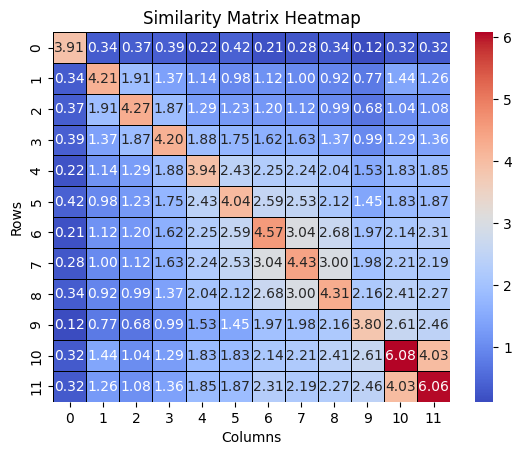

     0    1    2    3    4    5    6    7    8    9    10   11
0  3.91 0.34 0.37 0.39 0.22 0.42 0.21 0.28 0.34 0.12 0.32 0.32
1  0.34 4.21 1.91 1.37 1.14 0.98 1.12 1.00 0.92 0.77 1.44 1.26
2  0.37 1.91 4.27 1.87 1.29 1.23 1.20 1.12 0.99 0.68 1.04 1.08
3  0.39 1.37 1.87 4.20 1.88 1.75 1.62 1.63 1.37 0.99 1.29 1.36
4  0.22 1.14 1.29 1.88 3.94 2.43 2.25 2.24 2.04 1.53 1.83 1.85
5  0.42 0.98 1.23 1.75 2.43 4.04 2.59 2.53 2.12 1.45 1.83 1.87
6  0.21 1.12 1.20 1.62 2.25 2.59 4.57 3.04 2.68 1.97 2.14 2.31
7  0.28 1.00 1.12 1.63 2.24 2.53 3.04 4.43 3.00 1.98 2.21 2.19
8  0.34 0.92 0.99 1.37 2.04 2.12 2.68 3.00 4.31 2.16 2.41 2.27
9  0.12 0.77 0.68 0.99 1.53 1.45 1.97 1.98 2.16 3.80 2.61 2.46
10 0.32 1.44 1.04 1.29 1.83 1.83 2.14 2.21 2.41 2.61 6.08 4.03
11 0.32 1.26 1.08 1.36 1.85 1.87 2.31 2.19 2.27 2.46 4.03 6.06


NameError: name 'tootja' is not defined

In [ ]:
def main():
    """
    The main function that orchestrates the entire process: parsing arguments, loading the model,
    processing data, computing embeddings and similarities, fusing layers, and saving the modified model.
    """
    if '--f' in sys.argv:
        sys.argv.remove('--f')

    parser = argparse.ArgumentParser()
    # Define command-line arguments with descriptions and default values
    parser.add_argument("--ntrain", "-k", type=int, default=5, help="Number of training examples to include in prompts")
    parser.add_argument("--ngpu", "-g", type=int, default=4, help="Number of GPUs to use")
    parser.add_argument("--model_path", type=str, default="facebook/deit-tiny-patch16-224", help="Path to the pre-trained model")
    parser.add_argument("--num_tasks", "-n", type=int, default=57, help="Number of MMLU tasks to process (default: 57)")
    parser.add_argument("--num_samples", "-m", type=int, default=1, help="Number of samples per task (default: 1)")
    parser.add_argument("--data_dir", "-d", type=str, default=r"C:\Users\hp\Desktop\mka on VIT-mae\Pruning-via-Merging\val_csv", help="Directory containing the data")
    parser.add_argument("--num_layer", "-i", type=int, default=3, help="Number of layers to fuse (default: 1)")
    args = parser.parse_args([])

    # Extract the model name from the provided model path
    model_name = args.model_path.split("/")[-1]
    # Define the base directory for storing fused model information
    base_dir = f"/visual_data/yangzhao/point/EMNLP2024/layer_fus/al/{model_name}/fused_{args.num_layer}_layers"

    # Define directories for embeddings, fusion info, and merged weights
    iteration_dir = os.path.join(base_dir, f"iteration")
    embeddings_dir = os.path.join(iteration_dir, "embeddings")
    fusion_info_dir = os.path.join(iteration_dir, "fusion_info")
    merged_weights_dir = os.path.join(iteration_dir, "merged_weights")

    # Create the necessary directories if they don't exist
    os.makedirs(embeddings_dir, exist_ok=True)
    os.makedirs(fusion_info_dir, exist_ok=True)
    os.makedirs(merged_weights_dir, exist_ok=True)

    # Configure logging to write logs to a file within fusion_info_dir
    logging.basicConfig(filename=os.path.join(fusion_info_dir, 'experiment.log'), level=logging.INFO)
    # Set random seeds for reproducibility
    set_seed(1)

    # Initialize the tokenizer from the pre-trained model
    global tokenizer  # Declare as global to use in other functions if needed
    global model
    global cka_score_list
    global accuracy_score_list
    global label2id
    accuracy_score_list = []
    cka_score_list = []

    tokenizer = AutoImageProcessor.from_pretrained(
        args.model_path,
        use_fast=True,             # Use the fast tokenizer implementation
        trust_remote_code=True,    # Trust remote code (required for some models)
        add_bos_token=False,       # Do not add beginning-of-sequence token
        add_eos_token=False,       # Do not add end-of-sequence token
        padding_side="left"        # Pad sequences on the left side
    )

    # Load the pre-trained causal language model with appropriate settings
    model = ViTForImageClassification.from_pretrained(
        args.model_path,
        output_hidden_states=True,
        trust_remote_code=True,    # Trust remote code (required for some models)
        device_map="auto",         # Automatically map layers to available devices
        torch_dtype=torch.bfloat16 if torch.cuda.is_bf16_supported() else torch.float32,  # Use bfloat16 if supported
    )

    label2id = model.config.label2id 
    #'n03126707' - mechanical cranes (crane2) #model gives crane, 517 for mechanical cranes
    #n02012849 - biological cranes (crane) #model gives crane, 134 for biological cranes
    label2id.update({'crane':134, 'crane2':517})
    model = model.to(device)

    #checking the original model, with all the layers
    eval_result = eval_meth(classA, classB, num_images,num_images_accuracy , model)
    
    cka_score = eval_result[0].item()
    accuracy= eval_result[1]       
    cka_score_list.append(cka_score)
    accuracy_score_list.append(accuracy)


        #The model is set in evaluation mode by default using model.eval()
   # print(f"Initial model configuration: {model.config}")  # Display the model's configuration

    # Define the types of weights to be fused between layers
    # weight_types = [
    #     "mlp.down_proj.weight",
    #     "mlp.up_proj.weight", 
    #     "mlp.gate_proj.weight",
    #     "self_attn.k_proj.weight",
    #     "self_attn.o_proj.weight",
    #     "self_attn.q_proj.weight",
    #     "self_attn.v_proj.weight",
    # ]
    weight_types = [
    "attention.attention.query.weight",
    "attention.attention.key.weight",
    "attention.attention.value.weight",
    "attention.output.dense.weight",
    "intermediate.dense.weight",
    "output.dense.weight"
                    ]
    
    # Display metadata about the model
    print("Model metadata:")
    print(f"Number of layers: {len(model.vit.encoder.layer)}")
    print(f"Config num_hidden_layers: {model.config.num_hidden_layers}")

    # Identify all classes by listing test files and extracting subject names
    classes = list(IMAGENET2012_CLASSES.items())  #data
    

    num_layers = model.config.num_hidden_layers  # Total number of hidden layers in the model
    # Initialize a dictionary to store activations for each layer
    all_layers_activations = {i: [] for i in range(num_layers)}

    # Iterate over each subject up to the specified number of tasks
    for cur_count, (current_class,val) in enumerate(classes[:args.num_tasks]):
        # Load the test set for the current subject

        test_df = pd.read_csv(os.path.join(args.data_dir, current_class + ".csv"), header=None)  #data
        test_df = test_df[1:]
        # Determine the number of samples to process for the current subject
        num_samples = min(args.num_samples, test_df.shape[0])
        # Randomly select sample indices from the test set
        sample_indices = random.sample(range(test_df.shape[0]), num_samples)

        # Iterate over each selected sample index with a progress bar
        for index in tqdm(sample_indices, desc=f"Processing {cur_count}    {val}"):
            # Format the test example without the answer
            prompt = format_example(test_df, index)                #data format
            # Tokenize the prompt and move to GPU
            input_ids = tokenizer(prompt, return_tensors="pt").to(device)
            input_ids = input_ids.to(torch.bfloat16)
            # Iterate over each layer to extract activations
            for layer_idx in range(num_layers):
                activations = extract_layer_params(model, layer_idx, input_ids)
                # Append the extracted activations to the corresponding layer's list
                all_layers_activations[layer_idx].append(activations)

            # Clear memory after processing each sample to free up resources
            clear_memory()

    # Apply manifold learning (diffusion kernel) to the stacked activations of each layer
    for layer_idx in range(num_layers):
        # Stack all activations for the current layer vertically
        stacked_activations = np.vstack(all_layers_activations[layer_idx])
        # Compute the embedded activations using the diffusion kernel
        embedded_activations = diffusionKernel(stacked_activations, sigmaK=8, alpha=0.5, d=2, total_size=stacked_activations.shape[0])

        # Define the output file path for the embedded activations
        output_file = os.path.join(embeddings_dir, f"layer_{layer_idx}_embedded.pkl")
        # Save the embedded activations to a pickle file
        with open(output_file, "wb") as f:
            pickle.dump(embedded_activations, f)

    # Load all precomputed embeddings from the embeddings directory
    embeddings = load_embeddings(embeddings_dir)

    # Compute the similarity matrix based on the loaded embeddings
    similarity_matrix = compute_similarity_matrix_npib_global(embeddings)

    
    matrix = np.array(similarity_matrix)
    df = pd.DataFrame(matrix)
    sns.heatmap(df, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5, linecolor='black', cbar=True)
    # Set the title and labels
    plt.title("Similarity Matrix Heatmap")
    plt.xlabel("Columns")
    plt.ylabel("Rows")

    # Show the plot
    plt.show()
    pd.options.display.float_format = '{:.2f}'.format

    print(df)
    
    #sort the layers here -shivam

    # Merge layers iteratively from the last layer towards the first
    for _ in range(args.num_layer):
        if num_layers <= 1:
            break  # Stop if there is only one layer left

        # Define the indices of the two layers to fuse (last two layers)
        layer1_idx = num_layers - 2
        layer2_idx = num_layers - 1

        # Compute fusion ratios for the current pair of layers based on similarity
        fusion_ratios = compute_fusion_ratios(similarity_matrix, [(layer1_idx, layer2_idx)])
        adjusted_ratio_i, adjusted_ratio_j = fusion_ratios[0]

        print(f"Merging Layer {layer1_idx} (Fusion Ratio: {adjusted_ratio_i:.4f}) and Layer {layer2_idx} (Fusion Ratio: {adjusted_ratio_j:.4f})")

        # Perform the actual layer fusion using the computed ratios
        merged_model = layer_fusion(model, layer1_idx, layer2_idx, adjusted_ratio_i, weight_types)
        model = merged_model  # Update the model with the fused layers

        num_layers -= 1  # Decrement the layer count as one layer has been merged
         
        eval_result = eval_meth(classA, classB, num_images,num_images_accuracy,  model)
        
        cka_score = eval_result[0].item()
        accuracy= eval_result[1]       
        cka_score_list.append(cka_score)
        accuracy_score_list.append(accuracy)

        #eval code

    # Log the completion of layer fusion
    logging.info(f"Completed layer fusion with {args.num_layer} layers.")

    # Update the model's configuration to reflect the new number of hidden layers
    model.config.num_hidden_layers = num_layers
    # Save the model's configuration to the merged_weights directory
    model.config.save_pretrained(merged_weights_dir)

    # Save the fused model's state dictionary
    state_dict = model.state_dict()

    # Display the keys and tensor shapes from the state dictionary for verification
    print("Model state dict keys and tensor shapes after fusion:")
    for key, tensor in state_dict.items():
        print(f"{key}: {tensor.size()}")

    # Additionally, check and display tensor data types in the state dictionary
    print("\nChecking tensor data types in state dict:")
    for key, tensor in state_dict.items():
        print(f"{key}: {tensor.dtype}")

    # Define the save path for the merged model's state dictionary
    save_path = os.path.join(merged_weights_dir, "pytorch_model.bin")
    # Save the state dictionary to the specified path using PyTorch's save function
    torch.save(state_dict, save_path)
    print(f"Model successfully saved to {save_path}.")

    # Optional: Print example tensor values from the state dictionary for small tensors
    # This helps in verifying the actual data without overwhelming the output
    # print("\nExample tensor values from state dict (limited to small tensors for readability):")
    # for key, tensor in state_dict.items():
    #     if tensor.numel() < 10:  # Only print tensors with fewer than 10 elements
    #         print(f"{key}: {tensor.tolist()}")

if __name__ == "__main__":
    main()


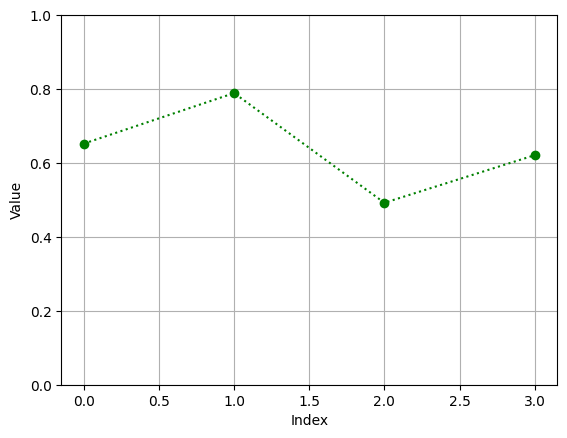

In [34]:
#vit_msn_base
#cka
plt.plot(cka_score_list, color='green', linestyle=':', marker='o')  # color, dotted line, and dots for points

plt.xlabel('Index')
plt.ylabel('Value')
plt.ylim(0, 1)

plt.grid(True)

plt.show()

#the best model will have a score of zero

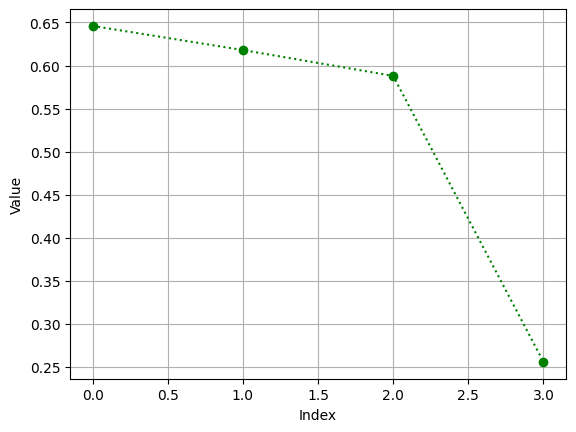

In [35]:
#vit_msn_base
#accuracy
plt.plot(accuracy_score_list, color='green', linestyle=':', marker='o')  # color, dotted line, and dots for points

plt.xlabel('Index')
plt.ylabel('Value')

plt.grid(True)

plt.show()
#the best model will have a score of zero

In [36]:
# to do 
# change the model.layers to encoder.layer
# vet the code
# also check ki abhi kya ho rha hai??
# give more power to a config and remove this command line bs

In [27]:
print(model.type)

<bound method Module.type of ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 192, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-8): 9 x ViTLayer(
          (attention): ViTSdpaAttention(
            (attention): ViTSdpaSelfAttention(
              (query): Linear(in_features=192, out_features=192, bias=True)
              (key): Linear(in_features=192, out_features=192, bias=True)
              (value): Linear(in_features=192, out_features=192, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=192, out_features=192, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
      

In [28]:
for n,v in model.named_parameters():
    print(n)

vit.embeddings.cls_token
vit.embeddings.position_embeddings
vit.embeddings.patch_embeddings.projection.weight
vit.embeddings.patch_embeddings.projection.bias
vit.encoder.layer.0.attention.attention.query.weight
vit.encoder.layer.0.attention.attention.query.bias
vit.encoder.layer.0.attention.attention.key.weight
vit.encoder.layer.0.attention.attention.key.bias
vit.encoder.layer.0.attention.attention.value.weight
vit.encoder.layer.0.attention.attention.value.bias
vit.encoder.layer.0.attention.output.dense.weight
vit.encoder.layer.0.attention.output.dense.bias
vit.encoder.layer.0.intermediate.dense.weight
vit.encoder.layer.0.intermediate.dense.bias
vit.encoder.layer.0.output.dense.weight
vit.encoder.layer.0.output.dense.bias
vit.encoder.layer.0.layernorm_before.weight
vit.encoder.layer.0.layernorm_before.bias
vit.encoder.layer.0.layernorm_after.weight
vit.encoder.layer.0.layernorm_after.bias
vit.encoder.layer.1.attention.attention.query.weight
vit.encoder.layer.1.attention.attention.query